# Flu Shot Learning: Predicting Seasonal Flu Vaccines

* Name: Robert Cauvy
* Email: rcauvy@gmail.com


## TABLE OF CONTENTS 


- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

![title](images/hero_viz.jpg)

# Business Problem

As the COVID-19 virus has spread throughout the world. Countries across the world are working to inoculate their populations and protect against future outbreaks. It is essential to know which populations are at risk of not receiving the vaccines. This information would help public health organizations optimally target their resources to informing and educating individuals about the immunizations.


At this stage of the COVID-19 pandemic, new variants has led to a large number of 'break through' cases. Public health officials have stated the best defense against new strains is to get vaccinated and take the recommended booster shots to greatly decrease the risk of hospitalization. 

While we don't know what will ultimately unfold, it is likely that we will need to get regular 'booster' shots to protect us from future variants of the virus, much like the seasonal flu vaccine. If we can learn what factors into an individual's choice to receive the seasonal flu vaccine, we can help governments inoculate their constituents.


# OBTAIN

A vaccine for the H1N1 flu virus became publicly available in October 2009. In late 2009 and early 2010, the United States conducted the National 2009 H1N1 Flu Survey. This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in conjunction with questions about themselves. These additional questions covered their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards mitigating transmission. A better understanding of how these characteristics are associated with personal vaccination patterns can provide guidance for future public health efforts.


We will be using a dataset from Data Driven competition (drivendata.org/competitions/66/flu-shot-learning/data/) that contains data provided courtesy of the United States National Center for Health Statistics, U.S. Department of Health and Human Services (DHHS), National Center for Health Statistics and the National 2009 H1N1 Flu Survey.

The dataset includes approximately 26,707 survey responses relating to the H1N1 and seasonal flu to train various machine learning algorithms in order to predict how likely an individual is to receive a vaccine.



## Imports

In [1]:
## Data Handling
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from random import randint

## Data Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Settings
from IPython.display import display
%matplotlib inline
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 100)
import warnings
warnings.filterwarnings('ignore')

## Scikit-Learn
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics 
from sklearn.multioutput import ClassifierChain
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

from sklearn import set_config
set_config(display='diagram')

import missingno

In [2]:
# Data Source
# https://www.drivendata.org/competitions/66/flu- -learning/data/

In [3]:
## Reading csv data and loading into a DataFrame

features_df = pd.read_csv('data/training_set_features.csv',index_col=0)
features_df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,1.00,2.00,2.00,1.00,2.00,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.00,0.00,NaN,NaN
1,3.00,2.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,5.00,4.00,4.00,4.00,2.00,4.00,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.00,0.00,pxcmvdjn,xgwztkwe
2,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,nan,1.00,0.00,0.00,nan,3.00,1.00,1.00,4.00,1.00,2.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.00,0.00,rucpziij,xtkaffoo
3,1.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,nan,3.00,3.00,5.00,5.00,4.00,1.00,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.00,0.00,NaN,NaN
4,2.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,3.00,3.00,2.00,3.00,1.00,4.00,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.00,0.00,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,3.00,1.00,1.00,5.00,2.00,2.00,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.00,0.00,NaN,NaN
26703,1.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,4.00,2.00,2.00,5.00,1.00,1.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.00,0.00,fcxhlnwr,cmhcxjea
26704,2.00,2.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,4.00,4.00,2.00,5.00,4.00,2.00,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.00,0.00,NaN,NaN


In [4]:
labels_df = pd.read_csv('data/training_set_labels.csv',index_col=0)
seas_labels_df = labels_df.drop('h1n1_vaccine',axis=1)
seas_labels_df

,seasonal_vaccine
respondent_id,
0,0
1,1
2,0
3,1
4,0
...,...
26702,0
26703,0
26704,1


In [5]:
# Confirming features and the labels rows match up. 
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

The assertion ran without an error, indicating the features and labels line up correctly.

In [6]:
# Joining Features and Labels Dataframes
joined_df = features_df.join(labels_df)
joined_df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,1.00,2.00,2.00,1.00,2.00,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.00,0.00,NaN,NaN,0,0
1,3.00,2.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,5.00,4.00,4.00,4.00,2.00,4.00,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.00,0.00,pxcmvdjn,xgwztkwe,0,1
2,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,nan,1.00,0.00,0.00,nan,3.00,1.00,1.00,4.00,1.00,2.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.00,0.00,rucpziij,xtkaffoo,0,0
3,1.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,nan,3.00,3.00,5.00,5.00,4.00,1.00,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.00,0.00,NaN,NaN,0,1
4,2.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,3.00,3.00,2.00,3.00,1.00,4.00,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.00,0.00,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,3.00,1.00,1.00,5.00,2.00,2.00,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.00,0.00,NaN,NaN,0,0
26703,1.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,4.00,2.00,2.00,5.00,1.00,1.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.00,0.00,fcxhlnwr,cmhcxjea,0,0
26704,2.00,2.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,4.00,4.00,2.00,5.00,4.00,2.00,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.00,0.00,NaN,NaN,0,1


The raw dataset contains 29 features, 1 target, and 26,707 instances.

In [7]:
# Dropping Features Specific to H1N1
seas_feats_df =features_df.drop(columns=['h1n1_concern','h1n1_knowledge','doctor_recc_h1n1',
                 'opinion_h1n1_vacc_effective','opinion_h1n1_risk',
                 'opinion_h1n1_sick_from_vacc'],axis=1)

In [8]:
# Joining Seasonal Vaccine Features and Seasonal Label Dataframes
seas_joined_df = seas_feats_df.join(seas_labels_df)
seas_joined_df

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,2.00,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.00,0.00,NaN,NaN,0
1,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,4.00,2.00,4.00,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.00,0.00,pxcmvdjn,xgwztkwe,1
2,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,1.00,0.00,0.00,nan,4.00,1.00,2.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.00,0.00,rucpziij,xtkaffoo,0
3,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,nan,5.00,4.00,1.00,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.00,0.00,NaN,NaN,1
4,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,nan,3.00,1.00,4.00,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.00,0.00,wxleyezf,emcorrxb,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,5.00,2.00,2.00,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.00,0.00,NaN,NaN,0
26703,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,5.00,1.00,1.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.00,0.00,fcxhlnwr,cmhcxjea,0
26704,0.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,nan,5.00,4.00,2.00,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.00,0.00,NaN,NaN,1


### Data Glossary

**behavioral_antiviral_meds** - Has taken antiviral medications. (binary)

**behavioral_avoidance** - Has avoided close contact with others with flu-like symptoms. (binary)

**behavioral_face_mask** - Has bought a face mask. (binary)

**behavioral_wash_hands** - Has frequently washed hands or used hand sanitizer. (binary)

**behavioral_large_gatherings** - Has reduced time at large gatherings. (binary)

**behavioral_outside_home** - Has reduced contact with people outside of own household. (binary)

**behavioral_touch_face** - Has avoided touching eyes, nose, or mouth. (binary)

**doctor_recc_h1n1** - H1N1 flu vaccine was recommended by doctor. (binary)

**doctor_recc_seasonal** - Seasonal flu vaccine was recommended by doctor. (binary)

**chronic_med_condition** - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

**child_under_6_months** - Has regular close contact with a child under the age of six months. (binary)

**health_worker** - Is a healthcare worker. (binary)

**health_insurance** - Has health insurance. (binary)

**opinion_seas_vacc_effective** - Respondent's opinion about seasonal flu vaccine effectiveness.\
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

**opinion_seas_risk** - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.\
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

**opinion_seas_sick_from_vacc** - Respondent's worry of getting sick from taking seasonal flu vaccine.\
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

**age_group** - Age group of respondent.

**education** - Self-reported education level.

**race** - Race of respondent.

**sex** - Sex of respondent.

**income_poverty** - Household annual income of respondent with respect to 2008 Census poverty thresholds.

**marital_status** - Marital status of respondent.

**rent_or_own** - Housing situation of respondent.

**employment_status** - Employment status of respondent.

**hhs_geo_region** - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.

**census_msa** - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

**household_adults** - Number of other adults in household, top-coded to 3.

**household_children** - Number of children in household, top-coded to 3.

**employment_industry** - Type of industry respondent is employed in. Values are represented as short random character strings.

**employment_occupation** - Type of occupation of respondent. Values are represented as short random character strings.

In [9]:
seas_feats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

Most of the data fields are stored as floats. Confirming with the data glossary, some fields are actually binary or ordinal categories. The other data fields are stored as objects but most are also able to be encoded into ordinal and  nominal categorical variables.

In [10]:
print(seas_labels_df['seasonal_vaccine'].value_counts(dropna=False))

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


Looks like there are target responses for every record in the dataset which is great. We won't have to drop any rows. See target proportions visualized below.

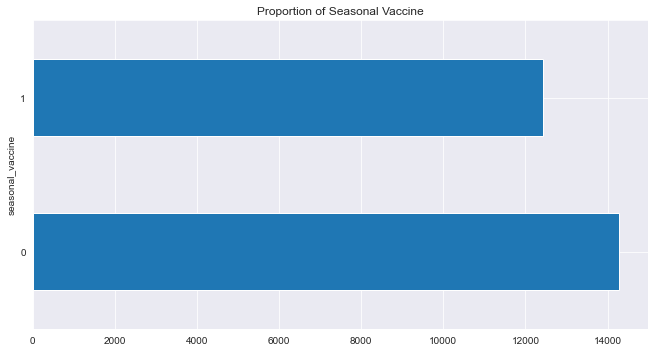

In [11]:
fig, ax = plt.subplots(figsize=(9.2, 5))

n_obs = labels_df.shape

(seas_labels_df['seasonal_vaccine']
    .value_counts()
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax)
)
ax.set_ylabel("seasonal_vaccine")

fig.tight_layout()

# SCRUB

Often times with survey collected data, there are some going to be missing responses. In order to process the data, each field will need to be evaluated to determine how missing values should be treated.

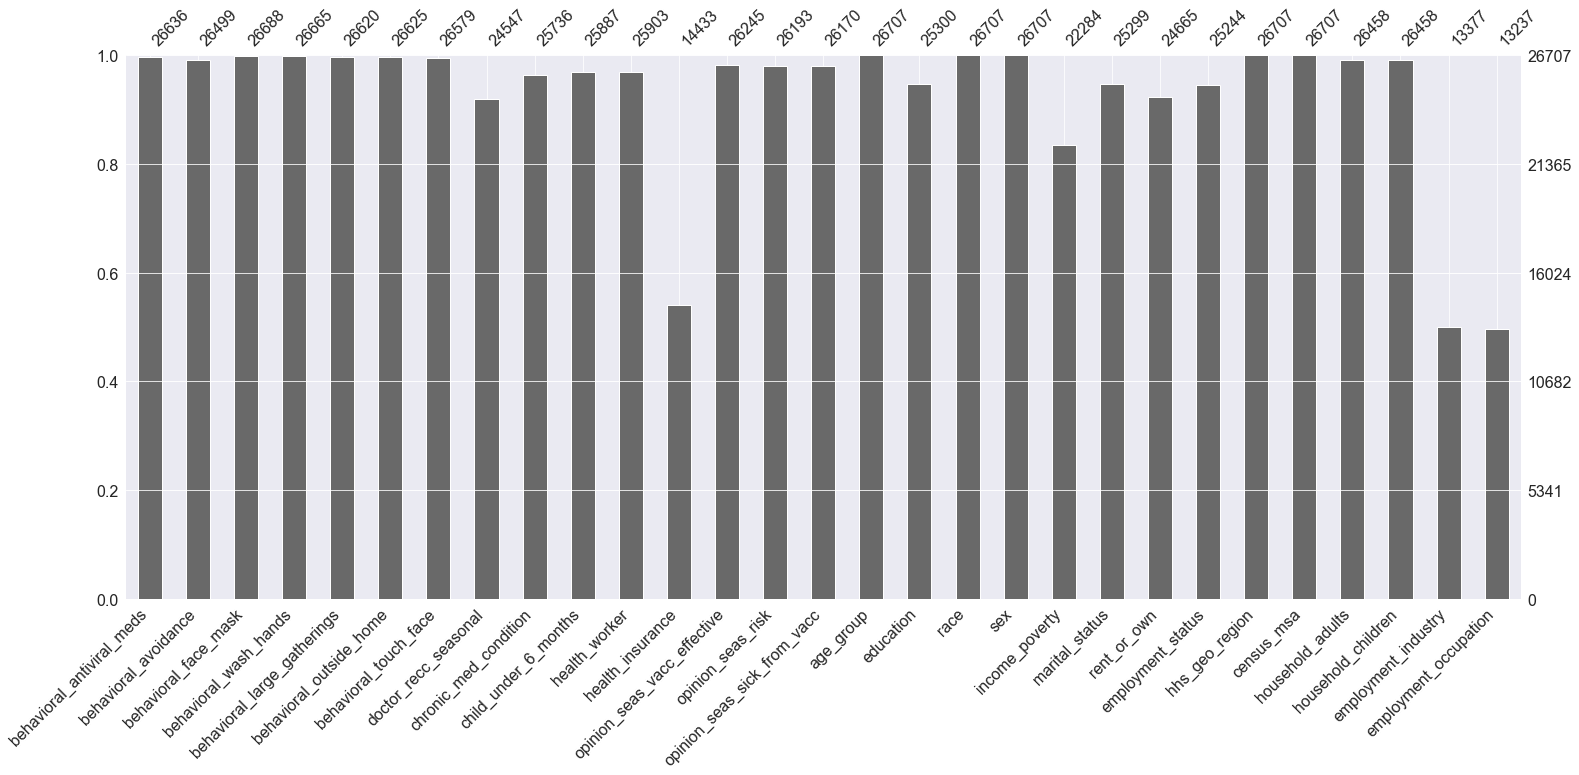

In [12]:
missingno.bar(seas_feats_df);

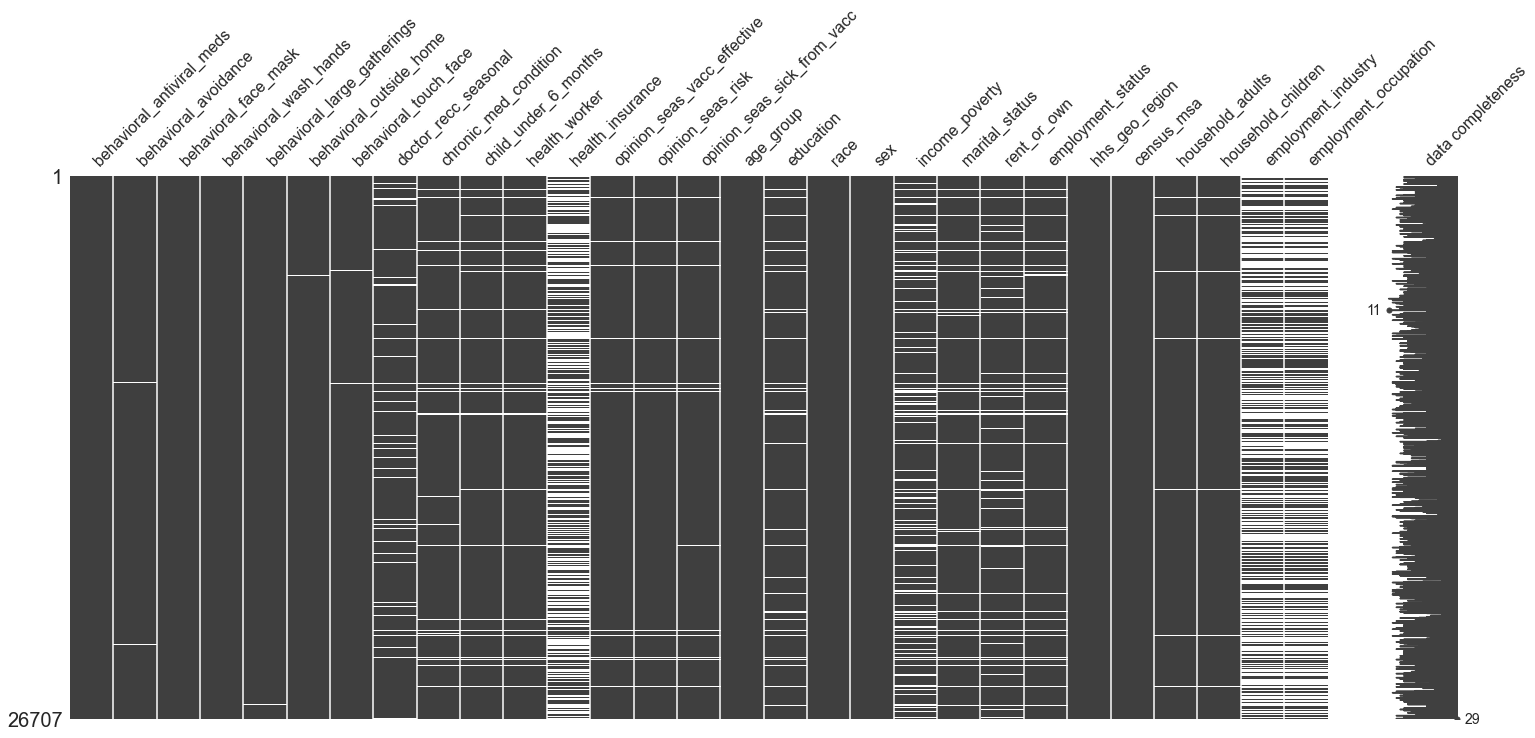

In [13]:
missingno.matrix(seas_feats_df, labels=True);

After inspecting the visualization, it is evident that the features missing the most responses are health insurance and employment details. Since these are categorical variables, we can create a new category and impute for the missing values. 

Instead of performing any manual updates to the remaining values, I will test different imputation methods as part of my modeling pipeline. </br></br> Potential methods would include:

Imputing the string "MISSING"
Imputing the most frequent value for string values
Using the mean, median, or mode for numeric datatypes
The benefit of including this step in a pipeline is that I will be able to include these different methods in a GridSearchCV as part of my hyperparameter turning steps.

# EXPLORE

In [22]:
joined_df['seasonal_vaccine'] = joined_df['seasonal_vaccine'].replace({0: 'Unvaccinated', 1: 'Vaccinated'})
joined_df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,1.00,2.00,2.00,1.00,2.00,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.00,0.00,NaN,NaN,0,Unvaccinated
1,3.00,2.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,5.00,4.00,4.00,4.00,2.00,4.00,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.00,0.00,pxcmvdjn,xgwztkwe,0,Vaccinated
2,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,nan,1.00,0.00,0.00,nan,3.00,1.00,1.00,4.00,1.00,2.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.00,0.00,rucpziij,xtkaffoo,0,Unvaccinated
3,1.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,nan,3.00,3.00,5.00,5.00,4.00,1.00,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.00,0.00,NaN,NaN,0,Vaccinated
4,2.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,3.00,3.00,2.00,3.00,1.00,4.00,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.00,0.00,wxleyezf,emcorrxb,0,Unvaccinated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,3.00,1.00,1.00,5.00,2.00,2.00,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.00,0.00,NaN,NaN,0,Unvaccinated
26703,1.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,4.00,2.00,2.00,5.00,1.00,1.00,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.00,0.00,fcxhlnwr,cmhcxjea,0,Unvaccinated
26704,2.00,2.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,nan,4.00,4.00,2.00,5.00,4.00,2.00,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.00,0.00,NaN,NaN,0,Vaccinated


In [23]:
counts = (joined_df[['opinion_seas_risk', 'seasonal_vaccine']]
              .groupby(['opinion_seas_risk', 'seasonal_vaccine'])
              .size()
              .unstack('seasonal_vaccine')
         )
counts

seasonal_vaccine,Unvaccinated,Vaccinated
opinion_seas_risk,,
1.00,4723,1251
2.00,5613,3341
3.00,300,377
4.00,2568,5062
5.00,755,2203


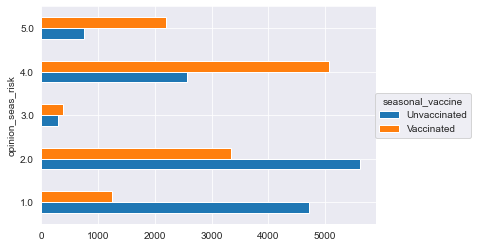

In [24]:
ax = counts.plot.barh()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='seasonal_vaccine'
);

In [25]:
seasonal_concern_counts = counts.sum(axis='columns')
seasonal_concern_counts

opinion_seas_risk
1.00    5974
2.00    8954
3.00     677
4.00    7630
5.00    2958
dtype: int64

In [26]:
props = counts.div(seasonal_concern_counts, axis='index')
props

seasonal_vaccine,Unvaccinated,Vaccinated
opinion_seas_risk,,
1.00,0.79,0.21
2.00,0.63,0.37
3.00,0.44,0.56
4.00,0.34,0.66
5.00,0.26,0.74


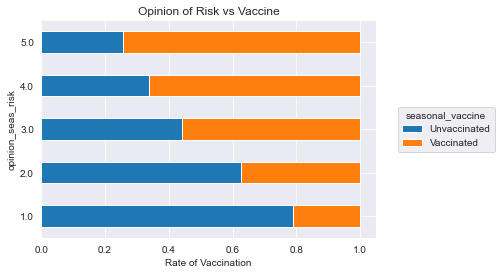

In [27]:
# Prototyping Stack Barh plot
ax = props.plot.barh(stacked=True)
ax.set_title('Opinion of Risk vs Vaccine')
ax.set_xlabel('Rate of Vaccination')
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='seasonal_vaccine'
);

In [28]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)

    ax.legend().remove()

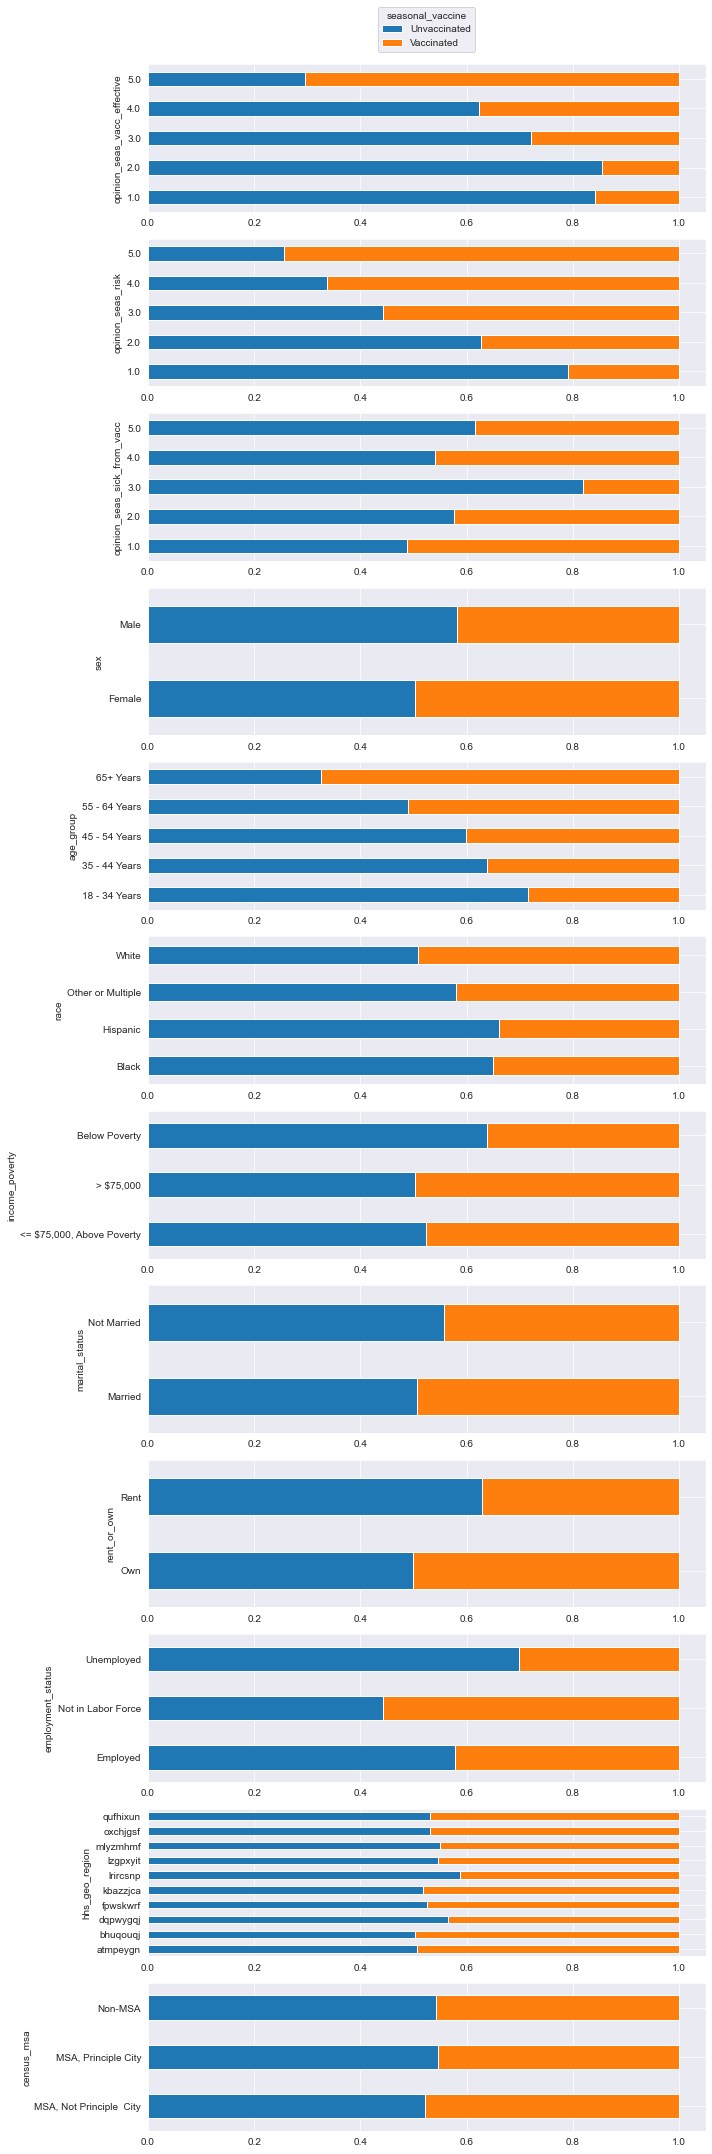

In [29]:
# Loop through several columns and plot against both h1n1_vaccine and seasonal_vaccine.

cols_to_plot = [
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',     
]

fig, ax = plt.subplots(
    len(cols_to_plot), figsize=(10,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx]
    )
    

ax[0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

After investigating the relationship among each feature and the target, a few columns stood out. First, the older someone is, the more likely they are to receive the vaccine. This is backed up by those not in the workforce having a higher likelihood of getting the shot than those employed and unemployed. Which is because most retired people are older. 

Also, the more someone is concerned about getting sick and the more effective they believe a vaccine to be, the more likely that are to get vaccinated. 

# MODEL

## Preprocessing

### Perform Train-Test-Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    seas_feats_df, 
    seas_labels_df, 
    test_size =.25, 
    random_state=42
)

X_train.head()

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25194,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,nan,4.00,2.00,2.00,18 - 34 Years,12 Years,White,Female,NaN,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.00,1.00,NaN,NaN
14006,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,4.00,5.00,4.00,45 - 54 Years,Some College,White,Female,NaN,Married,NaN,Employed,lzgpxyit,"MSA, Not Principle City",2.00,1.00,fcxhlnwr,oijqvulv
11285,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00,2.00,1.00,45 - 54 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,kbazzjca,"MSA, Principle City",0.00,1.00,wlfvacwt,hfxkjkmi
2900,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,4.00,4.00,2.00,55 - 64 Years,College Graduate,White,Male,Below Poverty,Not Married,Own,Employed,mlyzmhmf,"MSA, Not Principle City",0.00,0.00,mcubkhph,ukymxvdu
19083,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,nan,nan,nan,nan,1.00,2.00,4.00,18 - 34 Years,NaN,White,Female,NaN,NaN,NaN,NaN,bhuqouqj,"MSA, Not Principle City",nan,nan,NaN,NaN


In [31]:
y_train['seasonal_vaccine'].value_counts(normalize=True)

0   0.53
1   0.47
Name: seasonal_vaccine, dtype: float64

In [32]:
y_test['seasonal_vaccine'].value_counts(normalize=True)

0   0.54
1   0.46
Name: seasonal_vaccine, dtype: float64

### Impute Missing Values, Scaling and Encoding Pipelines

There are two important data preprocessing steps before jumping to the logistic regression:

Scaling: Transform all features to be on the same scale. This matters when using regularization, which we will discuss in the next section. We will use StandardScaler, also known as Z-score scaling. This scales and shifts features so that they have zero mean and unit variance.
NA Imputation: Logistic regression does not handle NA values. We will use median imputation, which fills missing values with the median from the training data, implemented with SimpleImputer.

In [33]:
# Copying the train test split
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

In [34]:
# Breaking out numerical and categorical columns to determine which 
# columns need to be sclaed and which need to be encoded.
#  make cat_cols and num_cols
cat_cols = X_train_tf.select_dtypes('O').columns.tolist()
num_cols = X_train_tf.select_dtypes('number').columns.tolist()
num_cols,cat_cols

(['behavioral_antiviral_meds',
  'behavioral_avoidance',
  'behavioral_face_mask',
  'behavioral_wash_hands',
  'behavioral_large_gatherings',
  'behavioral_outside_home',
  'behavioral_touch_face',
  'doctor_recc_seasonal',
  'chronic_med_condition',
  'child_under_6_months',
  'health_worker',
  'health_insurance',
  'opinion_seas_vacc_effective',
  'opinion_seas_risk',
  'opinion_seas_sick_from_vacc',
  'household_adults',
  'household_children'],
 ['age_group',
  'education',
  'race',
  'sex',
  'income_poverty',
  'marital_status',
  'rent_or_own',
  'employment_status',
  'hhs_geo_region',
  'census_msa',
  'employment_industry',
  'employment_occupation'])

#### Numerical Columns

In [35]:
# Create a transformer pipeline that will impute missing values using the 
# median and then standardize all numerical columns

num_tf = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())])

In [36]:
X_train_num_tf = num_tf.fit_transform(X_train[num_cols])
X_test_num_tf = num_tf.transform(X_test[num_cols])
X_train_num_tf

array([[-0.22644649, -1.62924603, -0.27402537, ..., -0.08933262,
         0.15110623,  0.50597212],
       [-0.22644649,  0.61378084, -0.27402537, ...,  1.42512566,
         1.48974303,  0.50597212],
       [-0.22644649, -1.62924603, -0.27402537, ..., -0.84656177,
        -1.18753056,  0.50597212],
       ...,
       [-0.22644649,  0.61378084, -0.27402537, ..., -0.08933262,
         0.15110623, -0.57309747],
       [-0.22644649,  0.61378084, -0.27402537, ...,  1.42512566,
         0.15110623, -0.57309747],
       [-0.22644649, -1.62924603, -0.27402537, ..., -0.08933262,
        -1.18753056, -0.57309747]])

#### Categorical Columns

In [37]:
# Create a transformer pipeline that will impute missing values using a 
# constany placeholder 'Unknown' and then OneHotEncode all numerical columns

cat_tf = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='Unknown')),
    ('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [38]:
X_train_cat_tf =cat_tf.fit_transform(X_train[cat_cols])
X_test_cat_tf =cat_tf.transform(X_test[cat_cols])

X_train_cat_tf

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

#### Combining together with ColumnTransformer

In [39]:
# Join both numerical and categorical Pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('Num',num_tf,num_cols),
    ('Cat',cat_tf,cat_cols)])
preprocessor

ColumnTransformer(transformers=[('Num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face',
                                  'doctor_recc_seasonal',
                                  'chronic_med_condi...
                                  'household_adults', 'household_children']),
                                ('Cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'hhs_geo_region', 'census_msa',
                                  'employment_industry',
                                  'employment_occupation'])])

In [40]:
## Get X_train and X_test from column transformer
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

In [41]:
cat_features = list(preprocessor.named_transformers_['Cat'].named_steps['ohe']
                    .get_feature_names(cat_cols))

In [42]:
X_cols = num_cols+cat_features

In [43]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index, columns=X_cols)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          index=X_test.index, columns=X_cols)


## Tranform X_train and X_test and make into DataFrames
X_train_df

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,education_Unknown,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_Unknown,marital_status_Married,marital_status_Not Married,marital_status_Unknown,rent_or_own_Own,rent_or_own_Rent,rent_or_own_Unknown,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_Unknown,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_Unknown,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_Unknown,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25194,-0.23,-1.63,-0.27,-2.16,-0.74,-0.71,-1.44,-0.66,-0.61,-0.29,-0.35,0.26,-0.03,-0.51,-0.09,0.15,0.51,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14006,-0.23,0.61,-0.27,0.46,-0.74,-0.71,-1.44,1.51,1.63,3.40,-0.35,0.26,-0.03,1.67,1.43,1.49,0.51,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11285,-0.23,-1.63,-0.27,-2.16,-0.74,-0

In [44]:
# Confirming Preprocessing CT
X_train_df.describe().round(2)

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,education_Unknown,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_Unknown,marital_status_Married,marital_status_Not Married,marital_status_Unknown,rent_or_own_Own,rent_or_own_Rent,rent_or_own_Unknown,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_Unknown,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_Unknown,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_Unknown,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
count,"20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.00","20,030.0

## Logistic Regression

### Fitting Model

In [45]:
# Fit a vanilla Logistic Regression to the Pipeline
lr_estimator = LogisticRegression()

In [46]:
# Combine preprocessing steps and model
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", lr_estimator),
])

In [47]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = pd.DataFrame(full_pipeline.predict(X_test))
preds.columns = seas_labels_df.columns

CPU times: user 1.2 s, sys: 78.6 ms, total: 1.27 s
Wall time: 862 ms


### Evaluating Model Performance

In [130]:
### Function to produce the model's coefficients
# Adapted from https://github.com/jirvingphd/Online-DS-FT-022221-Cohort-Notes-FLEX/blob/master/Phase_3/topic_25_logistic_regression/topic_25_pt2_LogisticRegression_titanic-v2-SG.ipynb

def eval_clf(model, X_test_tf,y_test,cmap='Reds',
                            normalize='true',classes=['Unvaccinated', 'Vaccinated'],figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model ([type]): [description]
        X_test_tf ([type]): [description]
        y_test ([type]): [description]
        cmap (str, optional): [description]. Defaults to 'Reds'.
        normalize (str, optional): [description]. Defaults to 'true'.
        classes ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (8,4).
        X_train ([type], optional): [description]. Defaults to None.
        y_train ([type], optional): [description]. Defaults to None.
    """
    
    
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    

    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    plt.grid(False)
    plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    for a in ax:
        a.grid(False)   
        
    curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
    curve.ax_.grid()
    curve.ax_.plot([0,1],[0,1],ls=':')
    fig.tight_layout()
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")

              precision    recall  f1-score   support

Unvaccinated       0.54      0.53      0.54      3634
  Vaccinated       0.45      0.47      0.46      3043

    accuracy                           0.50      6677
   macro avg       0.50      0.50      0.50      6677
weighted avg       0.50      0.50      0.50      6677



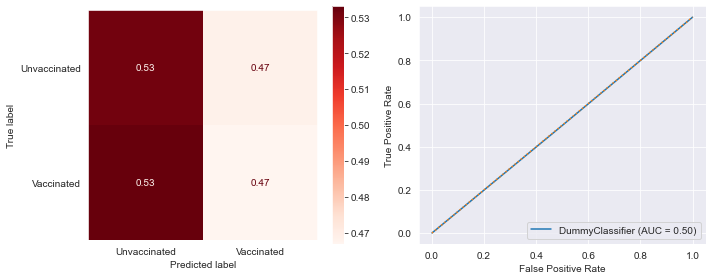

Training Score = 0.51
Test Score = 0.50


In [131]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_df, y_train)

eval_clf(base,X_test_tf,y_test,X_train=X_train_df,y_train=y_train)

              precision    recall  f1-score   support

Unvaccinated       0.80      0.82      0.81      3634
  Vaccinated       0.78      0.75      0.76      3043

    accuracy                           0.79      6677
   macro avg       0.79      0.78      0.79      6677
weighted avg       0.79      0.79      0.79      6677



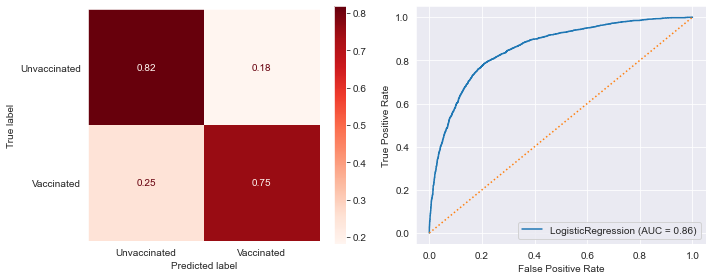

Training Score = 0.78
Test Score = 0.79


In [132]:
eval_clf(lr_estimator,X_test_tf,y_test,X_train=X_train_df,y_train=y_train)

### Hyperparameter Tuning With GridSearch 

In [143]:
# Logistic regression, optimized for recall
logreg = LogisticRegression(max_iter=600, class_weight='balanced')

param_grid = {
    'C':[0.01, 1, 100, 1e6],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

logreg_gs = GridSearchCV(logreg, param_grid, scoring='recall', n_jobs=-1,  
                     verbose=True)


logreg_gs.fit(X_train_df, y_train)

print(logreg_gs.best_estimator_)
print(logreg_gs.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.7min finished


LogisticRegression(C=1, class_weight='balanced', max_iter=600, penalty='l1',
                   solver='liblinear')
0.7711875722987267


In [144]:
logreg2 = LogisticRegression(max_iter=600, penalty='l1', solver='liblinear',C=1,class_weight='balanced')

In [152]:
# Re-run full pipeline with GS best parameter results
full_pipeline_2 = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", logreg2),
])

In [153]:
# Train model
full_pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_r...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('estimator',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=600,
                                    penalty='l1', solver='liblinear'))])

              precision    recall  f1-score   support

Unvaccinated       0.81      0.80      0.80      3634
  Vaccinated       0.76      0.77      0.77      3043

    accuracy                           0.79      6677
   macro avg       0.79      0.79      0.79      6677
weighted avg       0.79      0.79      0.79      6677



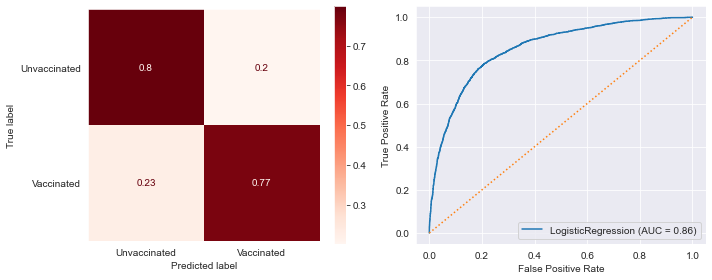

In [154]:
eval_clf(logreg2,X_test_df,y_test)

### Imputer Tuning With GridSearch

In [155]:
# Gridsearch Imputation Methods
gs_pipe = Pipeline([('ct',preprocessor),
                  ('clf',LogisticRegression())])



In [156]:
## Setting up params grid to change imputer params.
params = {'ct__Cat__imputer__strategy':['median','mean','most_frequent','constant'],
      'ct__Cat__imputer__fill_value':[0,-999]}

In [157]:
gridsearch = GridSearchCV(gs_pipe,params,n_jobs=-1,verbose=True,scoring='accuracy')

In [81]:
gridsearch.fit(X_train,y_train)
gridsearch.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.1s finished


{'ct__Cat__imputer__fill_value': 0,
 'ct__Cat__imputer__strategy': 'most_frequent'}

In [82]:
params = {'ct__Num__imputer':[SimpleImputer(),KNNImputer()]}

In [83]:
gridsearch = GridSearchCV(gs_pipe,params)

In [84]:
gridsearch.fit(X_train,y_train)
gridsearch.best_params_

{'ct__Num__imputer': KNNImputer()}

In [85]:
# Modify transformer pipeline with GridSearch best params

num_tf_2 = Pipeline(steps=[
    ('imputer',KNNImputer()),
    ('scaler',StandardScaler())])

In [86]:
X_train_num_tf_2 = num_tf_2.fit_transform(X_train[num_cols])
X_test_num_tf_2 = num_tf_2.transform(X_test[num_cols])
X_train_num_tf_2

array([[-0.22748413, -1.62115853, -0.27417699, ..., -0.09232227,
         0.15267519,  0.50139475],
       [-0.22748413,  0.62090495, -0.27417699, ...,  1.4178574 ,
         1.49018567,  0.50139475],
       [-0.22748413, -1.62115853, -0.27417699, ..., -0.8474121 ,
        -1.1848353 ,  0.50139475],
       ...,
       [-0.22748413,  0.62090495, -0.27417699, ..., -0.09232227,
         0.15267519, -0.57846771],
       [-0.22748413,  0.62090495, -0.27417699, ...,  1.4178574 ,
         0.15267519, -0.57846771],
       [-0.22748413, -1.62115853, -0.27417699, ..., -0.09232227,
        -1.1848353 , -0.57846771]])

In [87]:
# Update Categorical transformer pipeline to impute missing values with 'most
# frequent' and then OneHotEncode all numerical columns

cat_tf_2 = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [88]:
X_train_cat_tf_2 =cat_tf_2.fit_transform(X_train[cat_cols])
X_test_cat_tf_2 =cat_tf_2.transform(X_test[cat_cols])

X_train_cat_tf_2

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [89]:
# Join both numerical and categorical Pipelines using ColumnTransformer
preprocessor_2 = ColumnTransformer(transformers=[
    ('Num',num_tf_2,num_cols),
    ('Cat',cat_tf_2,cat_cols)])
preprocessor_2

ColumnTransformer(transformers=[('Num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face',
                                  'doctor_recc_seasonal',
                                  'chronic_med_condition',
                                  'child_under_6...
                                  'household_adults', 'household_children']),
                                ('Cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'hhs_geo_region', 'census_msa',
                                  'employment_industry',
                                  'employment_occupation'])])

In [90]:
## Get X_train and X_test from column transformer
X_train_tf_2 = preprocessor_2.fit_transform(X_train)
X_test_tf_2 = preprocessor_2.transform(X_test)

In [91]:
cat_features_2 = list(preprocessor_2.named_transformers_['Cat'].named_steps['ohe']
                    .get_feature_names(cat_cols))

In [92]:
X_cols_2 = num_cols+cat_features_2

In [93]:
X_train_df_2 = pd.DataFrame(preprocessor_2.transform(X_train),
                          index=X_train.index, columns=X_cols_2)
X_test_df_2 = pd.DataFrame(preprocessor_2.transform(X_test),
                          index=X_test.index, columns=X_cols_2)


## Tranform X_train and X_test and make into DataFrames
X_train_df_2

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25194,-0.23,-1.62,-0.27,-2.16,-0.75,-0.72,-1.44,0.60,-0.64,-0.30,-0.36,0.45,-0.03,-0.52,-0.09,0.15,0.50,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
14006,-0.23,0.62,-0.27,0.46,-0.75,-0.72,-1.44,1.47,1.61,3.39,-0.36,0.45,-0.03,1.66,1.42,1.49,0.50,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11285,-0.23,-1.62,-0.27,-2.16,-0.75,-0.72,-1.44,-0.71,-0.64,-0.30,-0.36,0.45,-0.03,-0.52,-0.85,-1.18,0.50,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0

In [159]:
# Combine preprocessing steps and model
full_pipeline_3 = Pipeline([
    ("preprocessor", preprocessor_2),
    ("estimator", logreg2),
])

In [160]:
# Train model with upodated parameter
full_pipeline_3.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_seasonal',
                                                   'chron...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('estimator',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=600,
                                    penalty='l1', solver='liblinear'))])

              precision    recall  f1-score   support

Unvaccinated       0.81      0.79      0.80      3634
  Vaccinated       0.76      0.77      0.76      3043

    accuracy                           0.78      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.78      0.78      0.78      6677



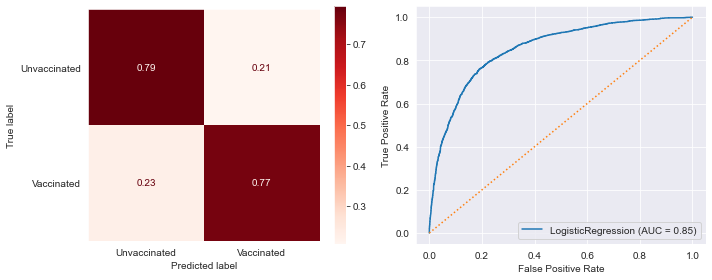

In [161]:
eval_clf(logreg2,X_test_tf_2,y_test)

Performance is not as great as the previous iteration.

## DecisionTree

### Fitting Model

In [167]:
## Create, fit, and evaluate a vanilla DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy')
dt_clf.fit(X_train_df, y_train)

DecisionTreeClassifier(criterion='entropy')

### Evaluating Model Performance

              precision    recall  f1-score   support

Unvaccinated       0.72      0.70      0.71      3634
  Vaccinated       0.66      0.68      0.67      3043

    accuracy                           0.69      6677
   macro avg       0.69      0.69      0.69      6677
weighted avg       0.69      0.69      0.69      6677



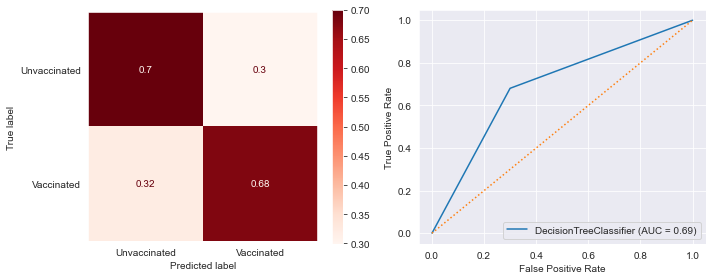

Training Score = 1.00
Test Score = 0.69


In [168]:
eval_clf(dt_clf, X_test_df,y_test,X_train=X_train_df,y_train=y_train)

The vanilla model is highly overfit, will need to prune the decision tree.

### Hyperparameter Tuning

In [173]:
params = {'max_depth':[None,3,5,10,20],
         'min_samples_leaf':[1,2,3,5],
         'criterion':['entropy','ginie']}


## Instantiate & Fit GridSearchCV optimized for recall
gridsearch = GridSearchCV(DecisionTreeClassifier(),params,scoring='recall',
                          n_jobs=-1)
gridsearch.fit(X_train_df,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'ginie'],
                         'max_depth': [None, 3, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 3, 5]},
             scoring='recall')

In [174]:
gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}

In [178]:
# Fit classifier with best parameters
dt_clf_2 = DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                  min_samples_leaf=1)
dt_clf_2.fit(X_train_df, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

              precision    recall  f1-score   support

Unvaccinated       0.75      0.85      0.79      3634
  Vaccinated       0.78      0.65      0.71      3043

    accuracy                           0.76      6677
   macro avg       0.77      0.75      0.75      6677
weighted avg       0.76      0.76      0.76      6677



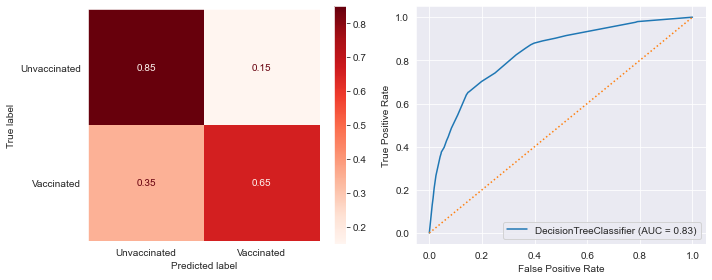

Training Score = 0.76
Test Score = 0.76


In [179]:
## Evaluate with the classifier
eval_clf(dt_clf_2,X_test_df,y_test,X_train=X_train_df,y_train=y_train)

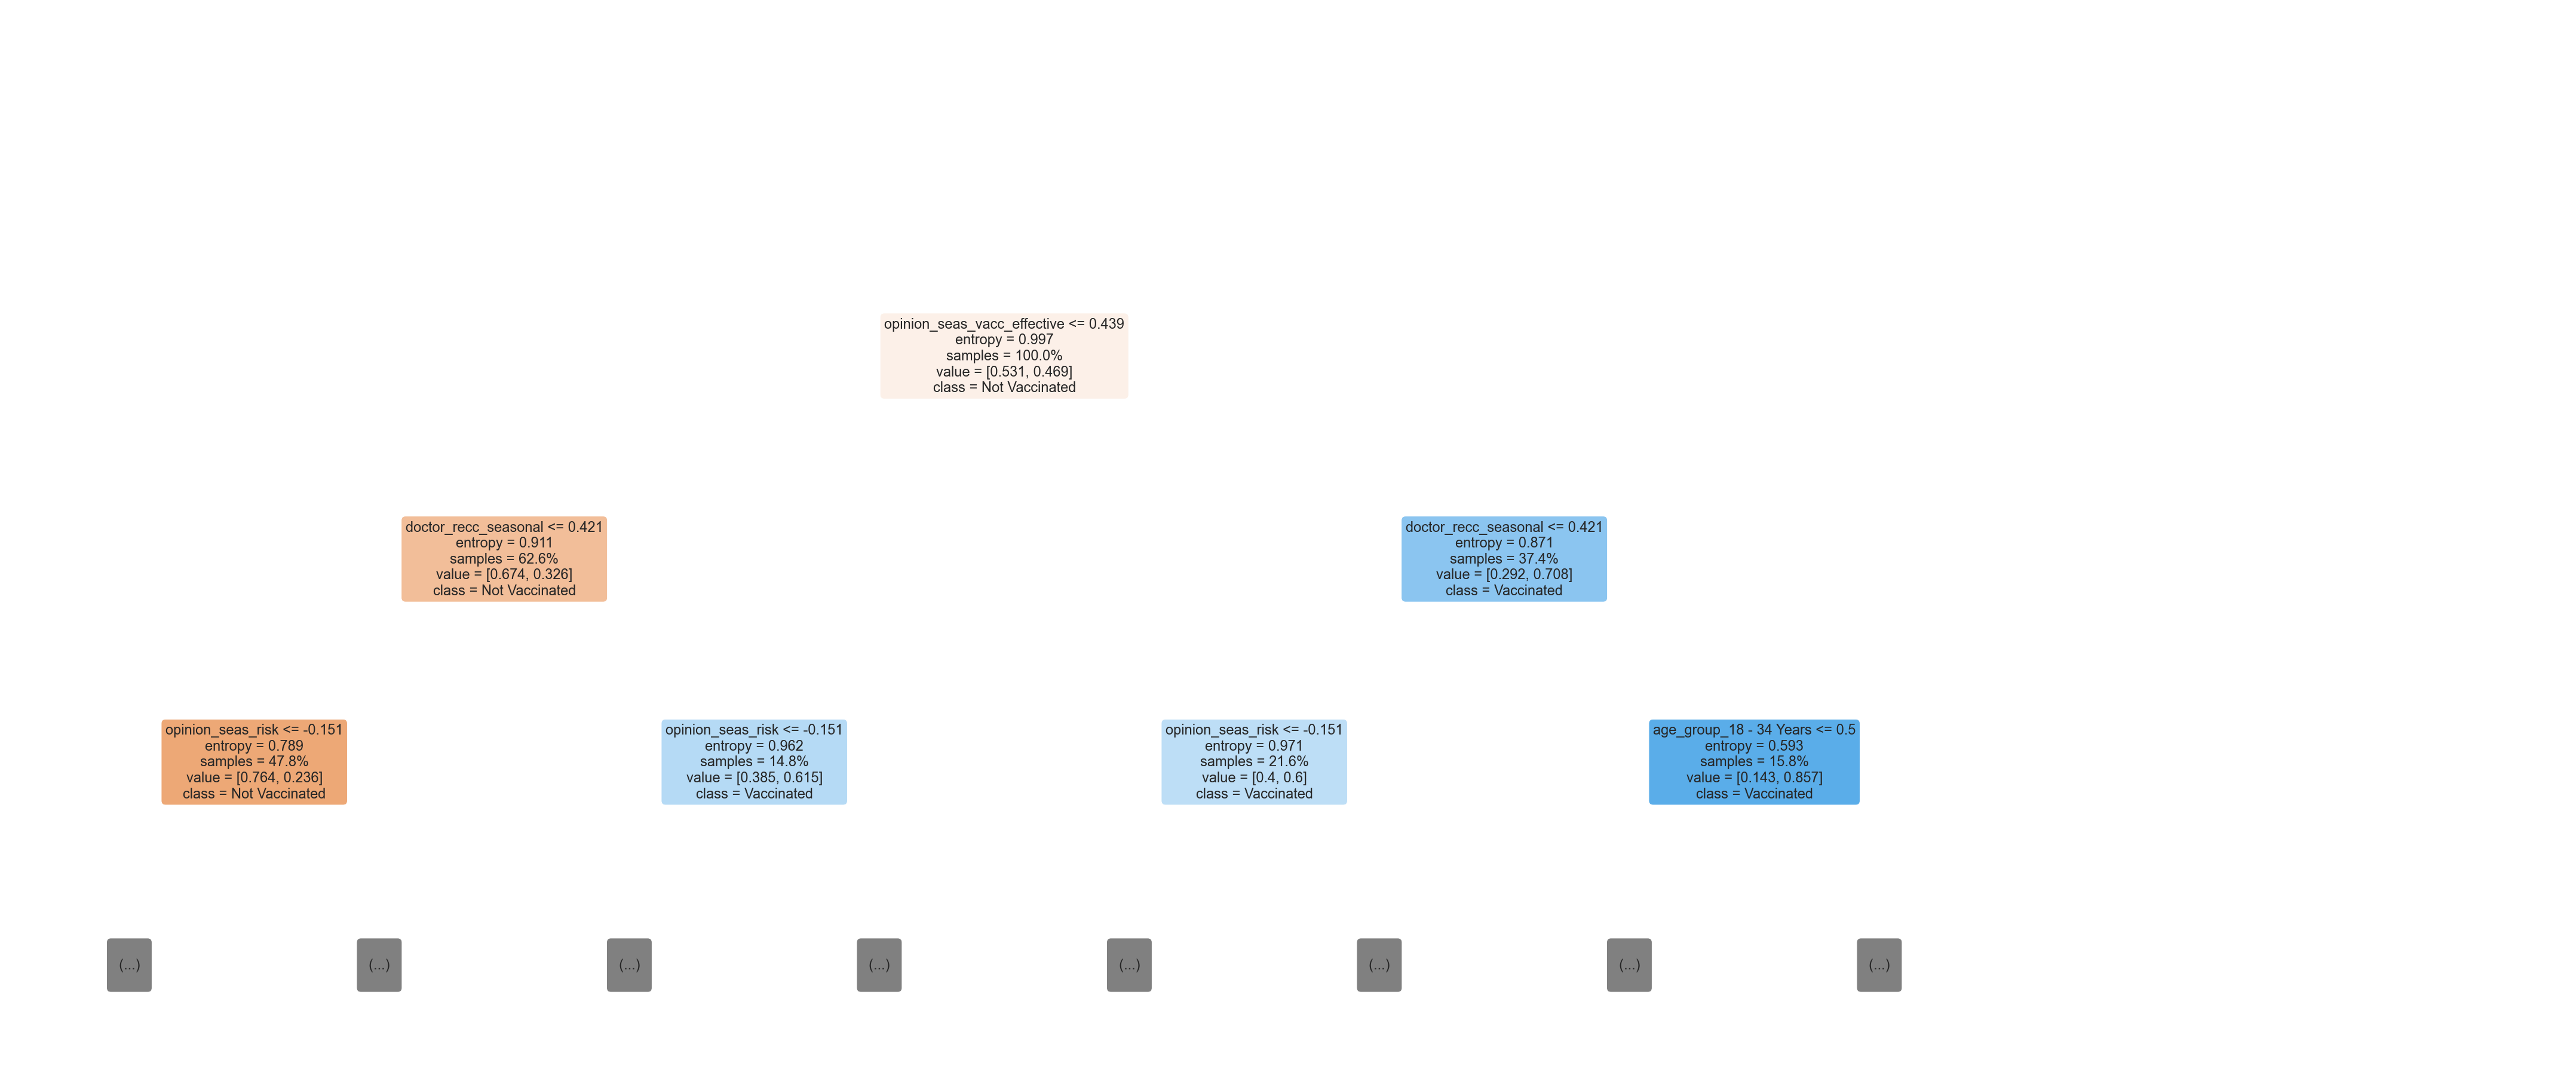

In [103]:
# Visualize Decision Tree with Sci-kit learn plot tree
from sklearn.tree import plot_tree

fig,ax = plt.subplots(figsize=(60,25))
plot_tree(dt_clf_2,max_depth=2,filled=True,rounded=True,proportion=True,
          feature_names=X_train_df.columns,
          class_names=['Not Vaccinated','Vaccinated'],ax=ax);
fig.tight_layout()
fig.savefig('vax_tree.pdf', dpi=300,orientation='landscape')


## Random Forest 

### Fitting Model

In [180]:
rf = RandomForestClassifier(class_weight='balanced')

In [181]:
rf.fit(X_train_df,y_train)

RandomForestClassifier(class_weight='balanced')

### Evaluating Model Performance

              precision    recall  f1-score   support

Unvaccinated       0.79      0.81      0.80      3634
  Vaccinated       0.76      0.74      0.75      3043

    accuracy                           0.78      6677
   macro avg       0.78      0.77      0.77      6677
weighted avg       0.78      0.78      0.78      6677



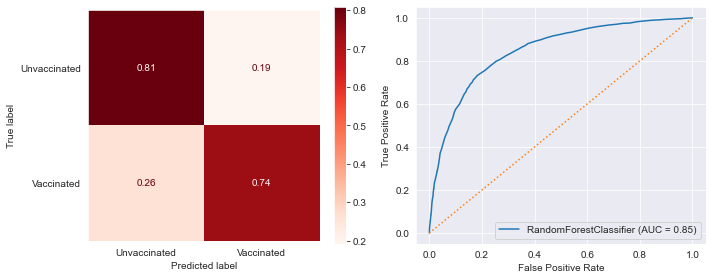

In [182]:
eval_clf(rf,X_test_tf,y_test)

### Hyperparameter Tuning

In [183]:
param_grid = {
    'n_estimators':[10, 50, 100],
    'criterion':['gini', 'entropy'],
    'max_depth': [3, 5, 10, 30],
    'min_samples_split': [1, 5, 20],
    'min_impurity_decrease': [0, 0.01, 0.02],
    'max_features': [10, 20],
    'max_leaf_nodes': [6000, 2000, 500]
}

In [184]:
# GridSearch optimized for accuracy
gs_rf = GridSearchCV(rf, param_grid, scoring='accuracy',cv=3,verbose=True,n_jobs=-1)

In [185]:
gs_rf.fit(X_train_df, y_train)

print(gs_rf.best_estimator_)
print(gs_rf.best_score_)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed: 16.8min finished


RandomForestClassifier(class_weight='balanced', max_depth=30, max_features=10,
                       max_leaf_nodes=500, min_impurity_decrease=0,
                       min_samples_split=20)
0.7775838104024442


In [109]:
# Review model performance for a model with these optimal params
rf_tuned = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                            max_depth=30, 
                            max_features=20, 
                            max_leaf_nodes=500, 
                            min_impurity_decrease=0,
                            min_samples_split=20)


rf_tuned.fit(X_train_df, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=20, max_leaf_nodes=500,
                       min_impurity_decrease=0, min_samples_split=20)

In [186]:
# GridSearch optimized for recall
gs_rf_recall = GridSearchCV(rf, param_grid, scoring='recall',cv=3,verbose=True,n_jobs=-1)

In [187]:
gs_rf_recall.fit(X_train_df, y_train)

print(gs_rf_recall.best_estimator_)
print(gs_rf_recall.best_score_)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed: 16.5min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=20, max_leaf_nodes=6000,
                       min_impurity_decrease=0.02, min_samples_split=20,
                       n_estimators=10)
0.8006891475502286


In [188]:
# Review model performance for a model with these optimal params
rf_tuned_2 = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                            max_depth=30, 
                            max_features=20, 
                            max_leaf_nodes=6000, 
                            min_impurity_decrease=0.02,
                            min_samples_split=20)


rf_tuned_2.fit(X_train_df, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=20, max_leaf_nodes=6000,
                       min_impurity_decrease=0.02, min_samples_split=20)

              precision    recall  f1-score   support

Unvaccinated       0.81      0.79      0.80      3634
  Vaccinated       0.75      0.78      0.77      3043

    accuracy                           0.78      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.78      0.78      0.78      6677



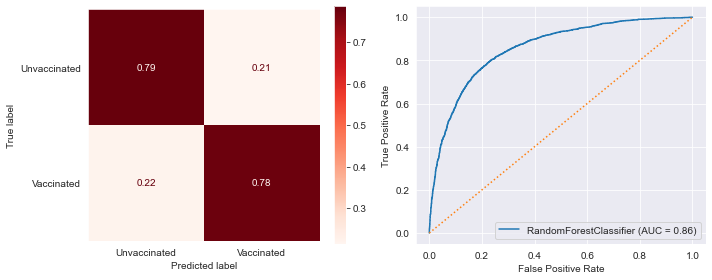

Training Score = 0.83
Test Score = 0.78


In [196]:
eval_clf(rf_tuned, X_test_df, y_test, X_train=X_train_df, y_train=y_train)

              precision    recall  f1-score   support

Unvaccinated       0.76      0.81      0.78      3634
  Vaccinated       0.75      0.70      0.72      3043

    accuracy                           0.76      6677
   macro avg       0.76      0.75      0.75      6677
weighted avg       0.76      0.76      0.76      6677



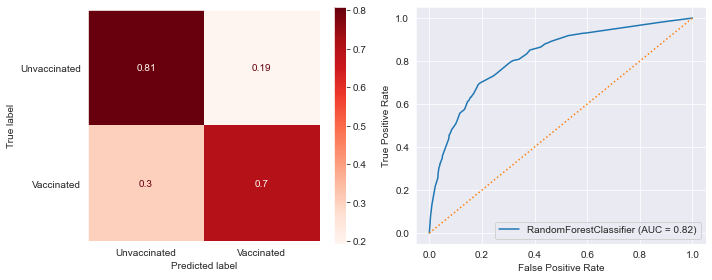

Training Score = 0.75
Test Score = 0.76


In [191]:
eval_clf(rf_tuned_2, X_test_df, y_test, X_train=X_train_df, y_train=y_train)

Recall score improves from 79 to 81% for the minority class. And less overfitting.

In [192]:
# Feature Selection with Sci-Kit Learns LinearSVC
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
  ('classification', RandomForestClassifier(class_weight='balanced', max_depth=30, max_features=20,
                       max_leaf_nodes=6000, min_impurity_decrease=0.02,
                       min_samples_split=20))
])

clf.fit(X_train_df, y_train)

Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LinearSVC())),
                ('classification',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        max_features=20, max_leaf_nodes=6000,
                                        min_impurity_decrease=0.02,
                                        min_samples_split=20))])

In [193]:
print('Trainging Score:'+str(clf.score(X_train_df, y_train)))
print('Testing Score:'+str(clf.score(X_test_df, y_test)))

Trainging Score:0.7209186220668996
Testing Score:0.719185262842594


              precision    recall  f1-score   support

Unvaccinated       0.77      0.69      0.73      3634
  Vaccinated       0.67      0.76      0.71      3043

    accuracy                           0.72      6677
   macro avg       0.72      0.72      0.72      6677
weighted avg       0.73      0.72      0.72      6677



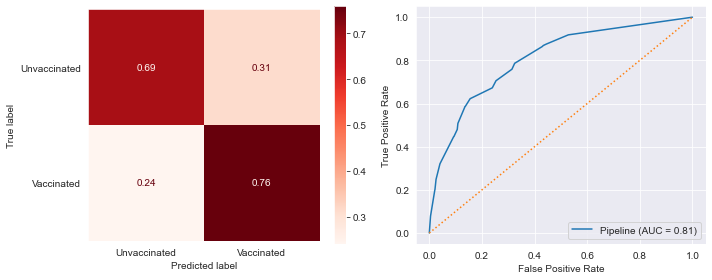

Training Score = 0.72
Test Score = 0.72


In [194]:
eval_clf(clf,X_test_df, y_test, X_train=X_train_df, y_train=y_train)

## XGBoost

### Fitting Model

In [114]:
from xgboost import XGBClassifier

In [115]:
bst = XGBClassifier()

In [116]:
bst.fit(X_train_df[num_cols],y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluating Model Performance

              precision    recall  f1-score   support

Unvaccinated       0.78      0.78      0.78      3634
  Vaccinated       0.74      0.73      0.73      3043

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



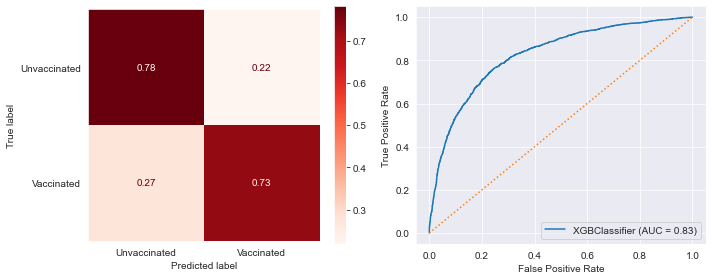

Training Score = 0.81
Test Score = 0.76


In [141]:
eval_clf(bst,
         X_test_df[num_cols],
         y_test, 
         X_train=X_train_df[num_cols], 
         y_train=y_train
        )

### Hyperparameter Tuning

In [118]:
params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [119]:
grid_boost= GridSearchCV(bst, 
                         params, 
                         scoring='accuracy', 
                         n_jobs=-1,
                         verbose=True)
grid_boost.fit(X_train_df[num_cols], y_train)

best_parameters = grid_boost.best_params_
best_parameters

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   50.7s finished


{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 100,
 'subsample': 0.7}

In [120]:
best_xgb = XGBClassifier(learning_rate=0.1, max_depth=6, min_child_weight=1,
                         n_estimators=100, subsample=0.7)
best_xgb.fit(X_train_df[num_cols], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

Unvaccinated       0.78      0.79      0.79      3634
  Vaccinated       0.74      0.74      0.74      3043

    accuracy                           0.77      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.77      0.77      0.77      6677



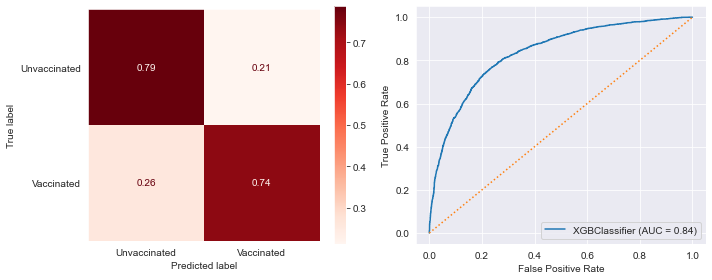

In [142]:
eval_clf(best_xgb, X_test_df[num_cols], y_test)

# iNTERPRET

After fitting and tuning 4 different classification models, we can parse out feature importances that have the most impact on determining whether someone will receive the vaccine or not. For this interpretation process, we will examine the feature importances of all 4 models to see if there is any patterns to recognize. If the models share some of the top features, we can interpret that as it being critical to their chance of getting vaccinated.

## Comparing Feature Importances

In [122]:
#accessing feature importance values of the tuned logistic regression model and sorting them
logreg_importances_df = pd.Series(logreg2.coef_[0], index=X_train_df_2.columns).sort_values(ascending=False)
#parsing the series to a dataframe
logregcv_importances_df = logreg_importances_df.reset_index()
logregcv_importances_df.columns = ['LogReg-Attribute', 'LogReg-Importance']
top_lr = logregcv_importances_df.head(15)
top_lr

,LogReg-Attribute,LogReg-Importance
0,employment_industry_haxffmxo,2.15
1,age_group_65+ Years,0.90
2,opinion_seas_risk,0.73
3,employment_occupation_dcjcmpih,0.70
4,employment_industry_msuufmds,0.65
5,opinion_seas_vacc_effective,0.61
6,doctor_recc_seasonal,0.57
7,employment_industry_arjwrbjb,0.30
8,employment_occupation_vlluhbov,0.26
9,employment_industry_mfikgejo,0.25


In [123]:
# accessing feature importance values of the tuned random forest model and sorting them
dt_importances_df = pd.Series(dt_clf_2.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)
#parsing the series to a dataframe
dt_importances_df = dt_importances_df.reset_index()
dt_importances_df.columns = ['DT-Attribute', 'DT-Importance']
top_dt = dt_importances_df.head(15)
top_dt

,DT-Attribute,DT-Importance
0,opinion_seas_vacc_effective,0.39
1,doctor_recc_seasonal,0.27
2,opinion_seas_risk,0.18
3,age_group_65+ Years,0.08
4,age_group_18 - 34 Years,0.04
5,health_worker,0.02
6,opinion_seas_sick_from_vacc,0.01
7,employment_industry_fcxhlnwr,0.00
8,household_children,0.00
9,"income_poverty_> $75,000",0.00


In [124]:
# accessing feature importance values of the tuned random forest model and sorting them
rf_importances_df = pd.Series(rf_tuned.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)
#parsing the series to a dataframe
rf_importances_df = rf_importances_df.reset_index()
rf_importances_df.columns = ['RF-Attribute', 'RF-Importance']
top_rf = rf_importances_df.head(15)
top_rf

,RF-Attribute,RF-Importance
0,opinion_seas_vacc_effective,0.18
1,opinion_seas_risk,0.17
2,doctor_recc_seasonal,0.15
3,age_group_65+ Years,0.06
4,opinion_seas_sick_from_vacc,0.03
5,age_group_18 - 34 Years,0.02
6,health_worker,0.02
7,household_children,0.01
8,chronic_med_condition,0.01
9,employment_industry_fcxhlnwr,0.01


In [125]:
#parsing feature importances to a series and sorting
xgb_importances_df = pd.Series(best_xgb.feature_importances_, index=X_train_df[num_cols].columns).sort_values(ascending=False)
#parsing the series to a dataframe
xgb_importances_df = xgb_importances_df.reset_index()
xgb_importances_df.columns=['XGB-Attribute', 'XGB-Importance']
top_xgb = xgb_importances_df.head(15)
top_xgb

,XGB-Attribute,XGB-Importance
0,doctor_recc_seasonal,0.31
1,opinion_seas_vacc_effective,0.21
2,opinion_seas_risk,0.11
3,health_insurance,0.05
4,health_worker,0.04
5,opinion_seas_sick_from_vacc,0.04
6,household_children,0.03
7,behavioral_touch_face,0.03
8,chronic_med_condition,0.03
9,household_adults,0.02


In [126]:
#Concatenating feature importances into a single dataframe
importances_df = pd.concat([top_lr, top_dt, top_rf, top_xgb], axis=1)
importances_df

,LogReg-Attribute,LogReg-Importance,DT-Attribute,DT-Importance,RF-Attribute,RF-Importance,XGB-Attribute,XGB-Importance
0,employment_industry_haxffmxo,2.15,opinion_seas_vacc_effective,0.39,opinion_seas_vacc_effective,0.18,doctor_recc_seasonal,0.31
1,age_group_65+ Years,0.90,doctor_recc_seasonal,0.27,opinion_seas_risk,0.17,opinion_seas_vacc_effective,0.21
2,opinion_seas_risk,0.73,opinion_seas_risk,0.18,doctor_recc_seasonal,0.15,opinion_seas_risk,0.11
3,employment_occupation_dcjcmpih,0.70,age_group_65+ Years,0.08,age_group_65+ Years,0.06,health_insurance,0.05
4,employment_industry_msuufmds,0.65,age_group_18 - 34 Years,0.04,opinion_seas_sick_from_vacc,0.03,health_worker,0.04
5,opinion_seas_vacc_effective,0.61,health_worker,0.02,age_group_18 - 34 Years,0.02,opinion_seas_sick_from_vacc,0.04
6,doctor_recc_seasonal,0.57,opinion_seas_sick_from_vacc,0.01,health_worker,0.02,household_children,0.03
7,employment_industry_arjwrbjb,0.30,employment_industry_fcxhlnwr,0.00,household_children,0.01,behavioral_touch_face,0.03
8,employment_occupation_vlluhbov,0.26,household_children,0.00,chronic_med_condition,0.01,chronic_med_condition,0.03
9,employment_industry_mfikgejo,0.25,"income_poverty_> $75,000",0.00,employment_industry_fcxhlnwr,0.01,household_adults,0.02


## Feature Importance Comparison

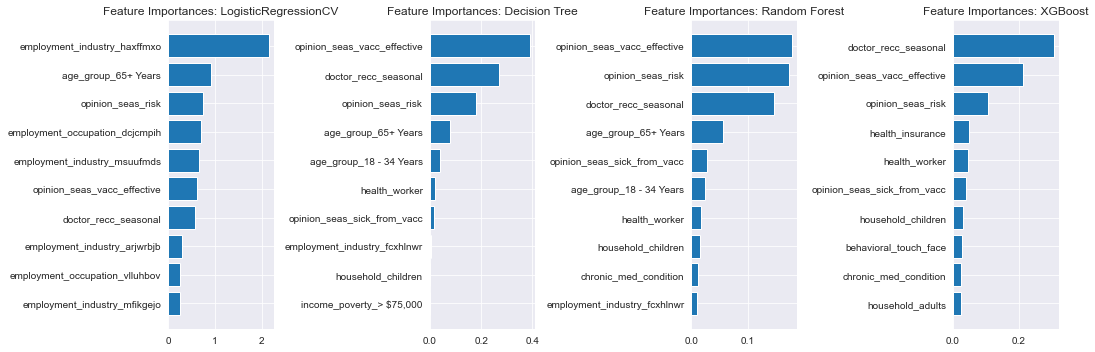

In [127]:
#plotting feature importances for all models for comparison

fig, ax = plt.subplots(ncols=4, figsize=(15,5))

logregcv_importances_df = logregcv_importances_df.sort_values(by='LogReg-Importance', ascending=True).tail(10)
ax[0].barh(logregcv_importances_df['LogReg-Attribute'], logregcv_importances_df['LogReg-Importance'])
ax[0].set_title('Feature Importances: LogisticRegressionCV')
plt.tight_layout()

dt_importances_df = dt_importances_df.sort_values(by='DT-Importance', ascending=True).tail(10)
ax[1].barh(dt_importances_df['DT-Attribute'], dt_importances_df['DT-Importance'])
ax[1].set_title('Feature Importances: Decision Tree')
plt.tight_layout()


rf_importances_df = rf_importances_df.sort_values(by='RF-Importance', ascending=True).tail(10)
ax[2].barh(rf_importances_df['RF-Attribute'], rf_importances_df['RF-Importance'])
ax[2].set_title('Feature Importances: Random Forest')

xgb_importances_df = xgb_importances_df.sort_values(by='XGB-Importance', ascending=True).tail(10)
ax[3].barh(xgb_importances_df['XGB-Attribute'], xgb_importances_df['XGB-Importance'])
ax[3].set_title('Feature Importances: XGBoost');

# CONCLUSIONS & RECOMMENDATIONS

## Best Model Results

Out of the 4 tuned classifier models, the Logistic Regression model was the best one in identifying vaccinations. 
It had a 79% accuracy score for identifying who received the vaccine compared to 53% by a baseline Dummy Classifier model. 
The next best performer was the RandomForest model at a very 78% accuracy. 


## Takeaways and Recommendations

In the midst of a pandemic with mutanting and evolving strains, it is vital to keep global populations up to date with immunizations. In order for public health groups to most effectively vaccinate their communities, it is essential to know both what and what does not lead someone to get a seasonal shot.

The most consistent top feature across all 4 models are: 
>1) A respondent's opinion about risk of getting sick with seasonal flu without vaccine\
>2)   Respondent's opinion about seasonal flu vaccine effectiveness.\
>3) If the seasonal flu vaccine was recommended by their doctor.


According to the WHO there are about 3 to 5 million cases of severe illness and 290,000 to 650,000 deaths from seasonal flu, worldwide that occur every year. The more the public is aware of this, the more like they are to get vaccinated.

Someone is also more likely to get a shot if they believe it will be effective at protecting them. The more trusted public figures, celebrities, family member speak up about the vaccines effectiveness will only improve society's vaccination rates. The same must also be said for the opposite. Social media platforms must be held accountant for the spread of misinformation.

And lastly, there is a much greater chance of somone getting vaccinated if it was recommnded by their doctor. 


Based off these findings Public Health Organizations can prioritize their messaging and actions to improve the likelihood that and individual will receive the flu vaccine. 


### Future Work

This project was limited by the features of this dataset. All of the columns were discrete, categorical variables. I believe the logistic regression and tree based models would have performed much better are predicting vaccines if they had continuous data for some features.

Also this survey data is aged over 10 years and based around the h1n1 flu. It would be advisable to update with more recent responses. 

- 